## Tutorial: Calculating RC's and COV for phantom PET scan

This tutorial is meant to provide an automated tool to determine the recovery coefficients (RCs) and coefficient of variation (COV) for a given PET image. The resulting measurements allow for an easy implementation of [Technical Note: how to determine the FDG activity for tumour PET imaging that satisfies European guidelines.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5040656/)

Required packages:
- `matplotlib`
- `pydicom`
- `skimage`
- `pandas`

In [1]:
from earl_nema import NemaRC

The necessary inputs are:
- `dicom_dir` - the path to the dicom files of your PET scan of interest.
- `S0` - the initial FDG activity concentration (in kBq/mL) in the spheres of the phantom.
- `t` - the time elapsed between the measurement of `S0` and when the PET scan of interest was taken.

In [2]:
# PET scan directory
time_step = 1
dicom_dir = ('../dicom/Teaghan/1.2.840._2362.263_PT_2019-12-09_174508_Upper.Extrem-_t'+
             str(time_step)+'.4p5min.TOF.QClear350_n89__00000')
# Initial FDG activity concentration in the spheres
S0 = 20.483 # kBq/mL
# Time elapsed since the measurement of S0
t = time_step*60 # min

The EANM class will run all of the necessary analyses on your given PET scan including the calculation of:

- $S_{true}$ - the true activity concentration (in kBq/mL) in the spheres at the time of the scan.
- $RC_{max}$ - the maximum activity concentration recovery coefficient of each sphere. This is defined as the maximum pixel value within a sphere (as measured on the reconstructed PET image) divided by the true FDG activity in the sphere.
- $RC_{mean}$ - the mean activity concentration recovery coefficient of each sphere. This is determined by creating a volume of interest (VOI) at 50% of the maximum pixel value. The mean pixel value within this VOI is divided by the true FDG activity in the sphere.
- $COV$ - the coefficient of variation of the image is determined by creating three regions of interest (ROIs) (each with an area of  900 mm$^2$) in three axial planes within the phantom of the reconstructed images. For each ROI, the image COV is determined by dividing the standard deviation by the mean pixel value within this ROI.

In order to calculate the RC's mentioned above, we need to create volumes of interest VOIs enclosing each sphere. We automate this process by utilizing the [`skimage.feature.blob_dog`](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_dog) function. This function detects "blobs" in the 3D image using the [Difference of Gaussian (DoG) method](https://en.wikipedia.org/wiki/Blob_detection#The_difference_of_Gaussians_approach). For each blob found, the method returns its coordinates and the standard deviation of the Gaussian kernel that detected the blob (which can be used to determine the radius). After locating the spheres, the calculation of $RC_{max}$ and $RC_{mean}$ is quite trivial.

Furthermore, the ROIs used to calculate the COV of the image are determined by using a fixed offset from two of the sphere centres, which makes this procedure fairly straight forward.

Currently the only parameters that can be varied are:

- `threshold` - The absolute lower bound for scale space maxima. Local maxima smaller than thresh are ignored. Reduce this to detect blobs with less intensities.
- `sigma_ratio` - The ratio between the standard deviation of Gaussian Kernels used for computing the Difference of Gaussians.

which can be tuned in order to successfully segment the 6 spheres. If doing so, only vary them in small increments (~0.05) as they can have a significant impact on the results.

In [3]:
threshold=0.1
sigma_ratio=1.5

results = NemaRC(dicom_dir, S0, t, threshold=threshold, sigma_ratio=sigma_ratio)

Reading dicom directory: ../dicom/Teaghan/1.2.840._2362.263_PT_2019-12-09_174508_Upper.Extrem-_t1.4p5min.TOF.QClear350_n89__00000
	Pet scan has shape: (89, 128, 128) and a resolution of (2.80, 5.47, 5.47)mm
Locating spheres using the Difference of Gaussian (DoG) method...
Calculating recovery coefficients for each sphere...
Calculating coefficient of variation...
Procedure complete.


Print the true activity concentration (in kBq/mL) in the spheres at the time of the scan.

In [4]:
results.S_true

14.022755231708985

Print the results from the analysis on the spheres including $RC_{max}$ and $RC_{mean}$

In [5]:
results.spheres

,"""Blob"" Radius (mm)",Z_loc (pixels),Y_loc (pixels),X_loc (pixels),S_max (kBq/mL),S_mean (kBq/mL),RC_max,RC_max EARL Compatible,RC_mean,RC_mean EARL Compatible
0,16.537500,35.0,64.0,73.0,27.166038,19.243175,1.937283,False,1.372282,False
1,16.537500,35.0,73.0,68.0,19.667687,15.225600,1.402555,False,1.085778,False
2,11.025000,35.0,74.0,58.0,14.283470,10.710025,1.018592,True,0.763760,True
3,6.445833,35.0,65.0,52.0,15.690793,10.353604,1.118952,False,0.738343,False
4,6.445833,35.0,56.0,57.0,15.387857,11.377987,1.097349,False,0.811395,False
5,5.512500,35.0,55.0,67.0,9.494223,7.494498,0.677058,False,0.534453,False


Plot the spheres found using the DoG to ensure that they are correct. If not, maybe try varying the sigma ratio slightly.

<IPython.core.display.Javascript object>


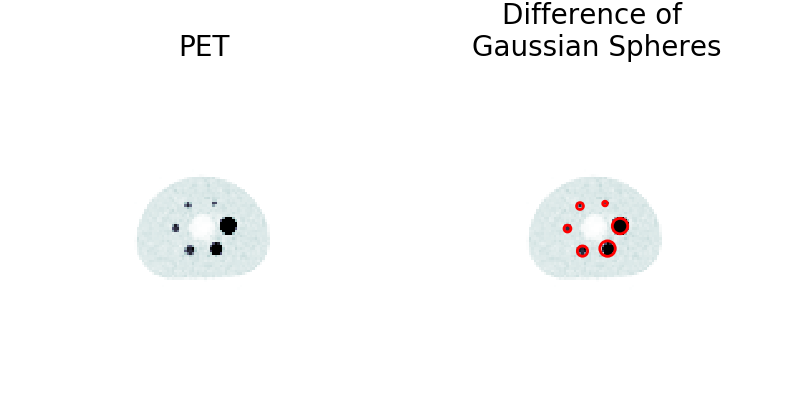

In [6]:
%matplotlib notebook
results.plot_spheres()

Plot the RC curves compared against the EARL ranges.

<IPython.core.display.Javascript object>


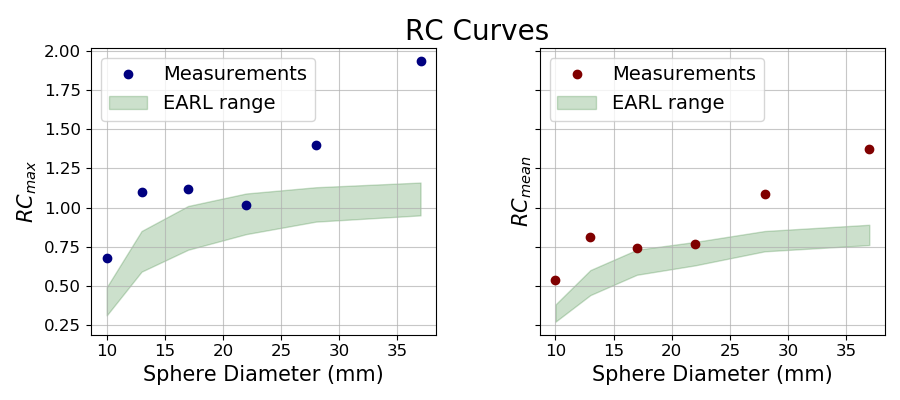

In [7]:
results.plot_RCs()

Print the Coefficient of Variation of the image.

In [8]:
results.COV

0.14348370382184875

Check against EANM guidelines.

In [9]:
results.check_COV()

The COV for this image is 14.3%, which is below the maximum of 15%. This meets the EANM guidelines.


Again, we can plot the ROIs used to calculate the COV to ensure they look ok.

<IPython.core.display.Javascript object>


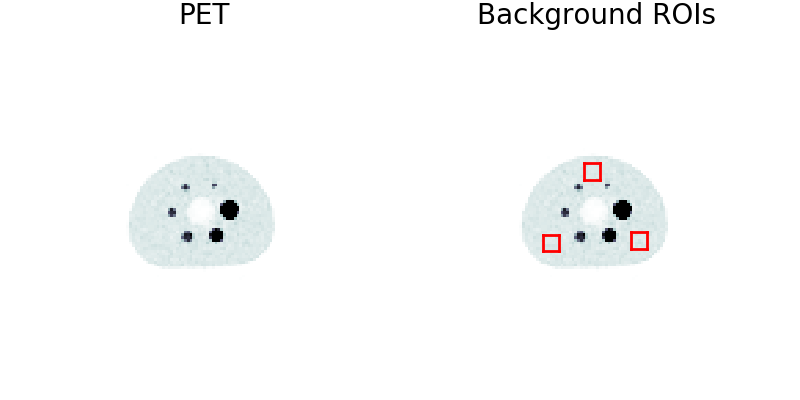

In [10]:
results.plot_ROIs()

**Note**: An improved way to select the 6 spheres (if this does not hold up at low S/N) would be to loosen the constraints used in the `skimage.feature.blob_dog` function to detect more spheres and only select the 6 spheres with the highest average pixel value.

Also, the VOIs used to calculate the $RC_{mean}$ values are NOT currently background corrected. This should be fixed. Maybe use the current *true* background activity concentration as a threshold.